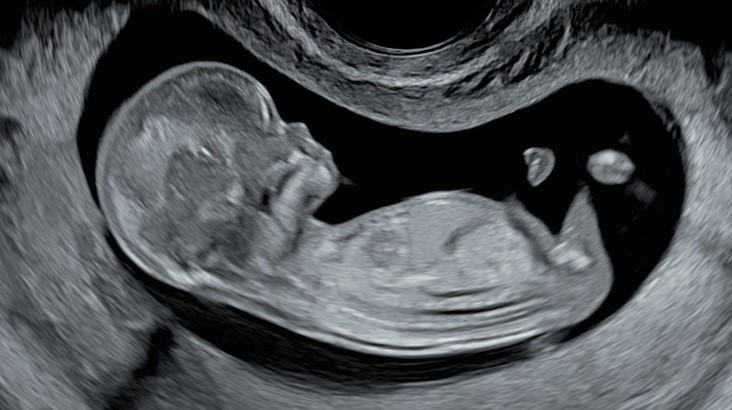

# FETAL HEAD SEGMENTATION-  Advancing medical image analysis and automation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.optim as optim
import cv2
from torchvision.transforms import CenterCrop

## Mounting Google Drive

All Images and Datasets are downloaded and then uploaded to Google Drive. Let us mount Google Drive ensuring Connection:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Checking if Image folder and Files are present:

In [ ]:
a=os.listdir('/content/drive/MyDrive/FetalHead_Segmentation/Ultrasound_CNN/test_set')
len(a)

336

In [ ]:
b=os.listdir('/content/drive/MyDrive/FetalHead_Segmentation/Ultrasound_CNN/training_set')
len(b)

1999

## Image Preprocessing and Reading

In [ ]:
n_train_cnt = 0
n_test_cnt = 0
train_file_name = []
test_file_name = []
max_width = 0
max_height = 0
min_width = 2000
min_height = 2000
base_path = '/content/drive/MyDrive/FetalHead_Segmentation/Ultrasound_CNN'
for path in os.listdir(base_path + "/training_set" ):
    f_path = os.path.join(base_path + "/training_set", path)
    if os.path.isfile(f_path):
        if '_Annotation' not in f_path:
          n_train_cnt += 1
          train_file_name.append(f_path[0:-4])
          img = cv2.imread(f_path, cv2.IMREAD_COLOR)
          if img is not None:
              if img.shape[0] > max_width:
                  max_width = img.shape[0]
              if img.shape[1] > max_height:
                  max_height = img.shape[1]
              if img.shape[0] < min_width:
                  min_width = img.shape[0]
              if img.shape[1] < min_height:
                  min_height = img.shape[1]
          else:
              print(f"Failed to read image: {f_path}")

for path in os.listdir(base_path + "/test_set" ):
    f_path = os.path.join(base_path + "/test_set", path)
    if os.path.isfile(f_path):
        n_test_cnt += 1
        test_file_name.append(f_path[0:-4])
        img = cv2.imread(f_path, cv2.IMREAD_COLOR)
        if img is not None:
            if img.shape[0] > max_width:
                max_width = img.shape[0]
            if img.shape[1] > max_height:
                max_height = img.shape[1]
            if img.shape[0] < min_width:
                min_width = img.shape[0]
            if img.shape[1] < min_height:
                min_height = img.shape[1]
        else:
            print(f"Failed to read image: {f_path}")
print(f'We Have {n_train_cnt} Images and {n_train_cnt} Annotations in Train Set  and {n_test_cnt} Images in Test Set. ')
print(f"Min Image Width: {min_width} - Min Image Height: {min_height}")
print(f"Max Image Width: {max_width} - Max Image Height: {max_height}")

Failed to read image: /content/drive/MyDrive/FetalHead_Segmentation/Ultrasound_CNN/training_set/Thumbs.db
Failed to read image: /content/drive/MyDrive/FetalHead_Segmentation/Ultrasound_CNN/test_set/Thumbs.db
We Have 1000 Images and 1000 Annotations in Train Set  and 336 Images in Test Set. 
Min Image Width: 539 - Min Image Height: 738
Max Image Width: 563 - Max Image Height: 800


In [ ]:
def seed_everything(seed=42):
	np.random.seed(seed)
	os.environ['PYTHONHASHSEED']=str(seed)
	os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8" # added so that Colab can run GPU for given Model Configuration
	np.random.seed(seed)
	torch.manual_seed(seed)

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

def read_images(file_name, img_width, img_height, title = "", suffix = "", transform = False):
  i = 0
  print('-'*50)
  print(title, '- Reading Images...')
  print('-'*50)
  j = 0
  cntr = 0
  mul = 1
  if transform:
    mul = 7
  total = len(file_name)

  channel = 3
  if 'Annotation' in suffix:
    channel = 1
  X_train = torch.tensor(np.ndarray((mul * total, channel, img_width, img_height), dtype=np.uint8))


  for label in file_name:
      img = cv2.imread(label + suffix, cv2.IMREAD_COLOR)
      if img is None:
        print(f"Failed to load image: {label + suffix}")
        continue
      img1 = cv2.cvtColor(img, cv2.IMREAD_COLOR)
      if channel == 1:
        image = cv2.imread(label + suffix, 0)
        im = image.copy()
        im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
        contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for c in contours:
            ellipse = cv2.fitEllipse(c)
            cv2.ellipse(im, ellipse, (255,255,255), -1)
        img1 = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

      # Resize Images
      scale_width =   img.shape[0] / img_width
      if img.shape[1] / img_height > scale_width:
        scale_width = img.shape[1] / img_height
      img1 = cv2.resize(img1, (int(img.shape[1] / scale_width), int(img.shape[0] / scale_width)))

      # Center Image
      top = int((img_height-img1.shape[1])/2)
      bottom = img_height-img1.shape[1] - top
      left = int((img_width-img1.shape[0])/2)
      right = img_width-img1.shape[0] - left
      img1 = cv2.copyMakeBorder(img1,left, right, top, bottom,  borderType=cv2.BORDER_CONSTANT, value=(0,0,0,0))

      # transform Image
      if transform:
        base_img = []
        base_img.append(img1)
        base_img.append(rotate_image(img1, 30))
        base_img.append(rotate_image(img1, 60))
        if '_Annotation' not in suffix:
          base_img.append(cv2.blur(np.array(img1) ,(10,10)))
        else:
          base_img.append(img1)
        base_img.append(cv2.flip(np.array(img1) ,0))
        base_img.append(cv2.flip(np.array(img1) ,1))
        base_img.append(cv2.flip(np.array(img1) ,-1))
        for m in range(0, 7):
          img = base_img[m]
          # Convert to n,c,w,h
          image = torch.from_numpy(img)
          image = image[np.newaxis, :]
          if channel == 3:
            image = image.permute(0, 3, 1, 2)
          X_train[j + m] = image
        j += 4
      else:
        image = torch.from_numpy(img1)
        image = image[np.newaxis, :]
        if channel == 3:
          image = image.permute(0, 3, 1, 2)
        X_train[j] = image
        j += 1

      if cntr % 100 == 0:
          print('Read: {0}/{1} images'.format(cntr, total))
      cntr += 1

  print(title, ' - Reading Completed')
  return X_train


In [ ]:
total_train = len(train_file_name)
total_test = len(test_file_name)
img_width = 224 # int(min_width / 4)
img_height = 224 # int(min_height / 4)

# Reading Train Images
X_train = read_images(train_file_name[0:700], img_width, img_height, title = "Train Images", suffix = ".png", transform = False)
X_validation = read_images(train_file_name[700:], img_width, img_height, title = "Validation Images", suffix = ".png", transform = False)
# Reading Train Annotations
Y_train = read_images(train_file_name[0:700], img_width, img_height, title = "Train Annotations", suffix = "_Annotation.png", transform = False)
Y_validation = read_images(train_file_name[700:], img_width, img_height, title = "Validation Annotations", suffix = "_Annotation.png", transform = False)
# Reading Test Images
X_test = read_images(test_file_name, img_width, img_height, title = "Test Images", suffix = ".png", transform = False)

print('Total Train Image Set Shape: ', X_train.shape)
print('Total Train Annotation Set Shape: ', Y_train.shape)
print('Total Validation Image Set Shape: ', X_validation.shape)
print('Total Validation Annotation Set Shape: ', Y_validation.shape)
print('Total Test Image Set Shape: ', X_test.shape)

--------------------------------------------------
Train Images - Reading Images...
--------------------------------------------------
Read: 0/700 images
Read: 100/700 images
Read: 200/700 images
Read: 300/700 images
Read: 400/700 images
Failed to load image: /content/drive/MyDrive/FetalHead_Segmentation/Ultrasound_CNN/training_set/Thumb.png
Read: 500/700 images
Read: 600/700 images
Train Images  - Reading Completed
--------------------------------------------------
Validation Images - Reading Images...
--------------------------------------------------
Read: 0/300 images
Read: 100/300 images
Read: 200/300 images
Validation Images  - Reading Completed
--------------------------------------------------
Train Annotations - Reading Images...
--------------------------------------------------
Read: 0/700 images
Read: 100/700 images
Read: 200/700 images
Read: 300/700 images
Read: 400/700 images
Failed to load image: /content/drive/MyDrive/FetalHead_Segmentation/Ultrasound_CNN/training_set/T

## Let us plot the Train Images - Along with the Segmentation and first 4 Test

---

Images

---



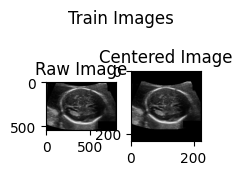

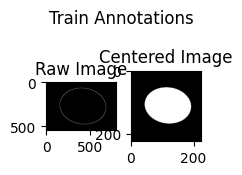

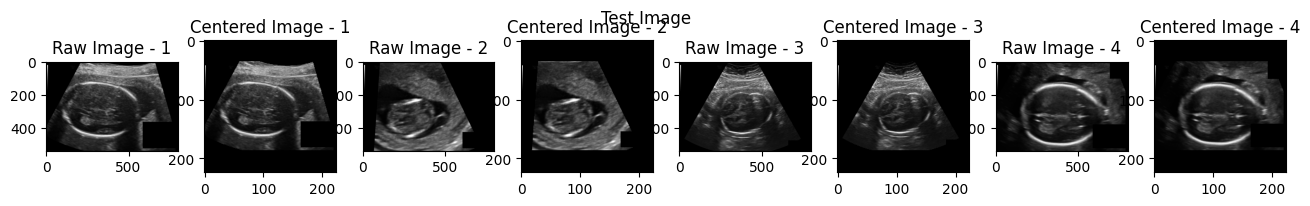

In [ ]:
# Visualize Train Images and Annotations
img = cv2.imread(train_file_name[0] + ".png", cv2.IMREAD_COLOR)
fig, axis = plt.subplots(1, 2, figsize=(2, 2))
fig.suptitle('Train Images')
axis[0].imshow(img)
axis[0].set_title('Raw Image')
axis[1].imshow(X_train[0].permute(1, 2, 0))
axis[1].set_title('Centered Image')
plt.show()

img = cv2.imread(train_file_name[0] + "_Annotation.png", cv2.IMREAD_COLOR)
fig, axis = plt.subplots(1, 2, figsize=(2, 2))
fig.suptitle('Train Annotations')
axis[0].imshow(img)
axis[0].set_title('Raw Image')
axis[1].imshow(Y_train[0].permute(1, 2, 0), cmap='gray')
axis[1].set_title('Centered Image')
plt.show()

# Visualize Test Images
fig, axis = plt.subplots(1, 8, figsize=(16, 2))
fig.suptitle('Test Image')
for i in range(0, 4):
    img = cv2.imread(test_file_name[i] + ".png", cv2.IMREAD_COLOR)
    axis[2 * i].imshow(img)
    axis[2 * i].set_title(f'Raw Image - {i + 1}')
    axis[2 * i + 1].imshow(X_test[i].permute(1, 2, 0))
    axis[2 * i + 1].set_title(f'Centered Image - {i + 1}')

plt.show()


# Let us then define the DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Creating Tensor Datasets for training, validation, and test data and normalizing them
train_dataset = TensorDataset(torch.Tensor(X_train/255), torch.Tensor(Y_train/255))
validation_dataset = TensorDataset(torch.Tensor(X_validation/255), torch.Tensor(Y_validation/255))
test_dataset = TensorDataset(torch.Tensor(X_test/255))

# Defining batch size for DataLoader
batch_size = 32

# Creating DataLoader for training data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=False)

# Creating DataLoader for validation data
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                                batch_size=batch_size,
                                                shuffle=False)

# Creating DataLoader for test data
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)



Let us build custom encoder - decoder model. We try to mimic SegNet Architecture - Though with lesser number of channels across the model since more channels causes Colab GPU to go over memory.

Our Encoder will Convolve with Channels: 3, 16, 32, 64 and then Decoder will go back to 64, 32, 16, 1 - We use Sigmoid and BCE Loss to calculate the final Segmentation Mask:

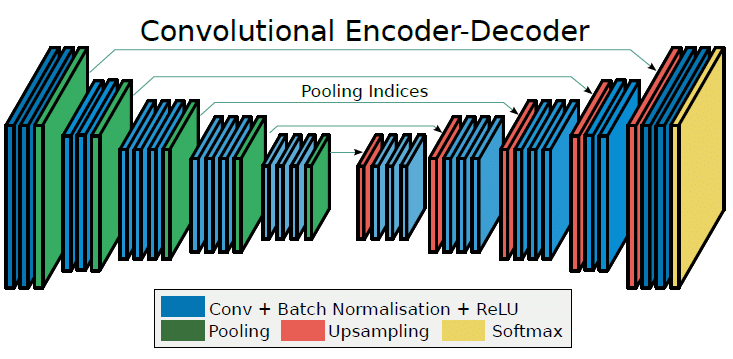

In [ ]:
class ResEncoderBlock(nn.Module):
  def __init__(self, inChannels, outChannels, layers = 2):
    super().__init__()
    self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(outChannels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(outChannels)
    self.layers = layers
    self.MaxEn = nn.MaxPool2d(2, stride=2, return_indices=True)
    self.size = 0

  def forward(self, x):
    # CONV -> Batch Norm -> RELU
    x = self.relu(self.bn1(self.conv1(x)))
    for i in range(1, self.layers):
      x = self.relu(self.bn2(self.conv2(x)))
    x, ind1 = self.MaxEn(x)
    return x, ind1

class ResDecoderBlock(nn.Module):
  def __init__(self, inChannels, outChannels, layers = 2):
    super().__init__()
    self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(outChannels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(outChannels)
    self.layers = layers
    self.MaxDe = nn.MaxUnpool2d(2, stride=2)

  def forward(self, x, poolingIndices, size):

    x = self.MaxDe(x, poolingIndices, output_size =size)
    x = self.relu(self.bn1(self.conv1(x)))
    for i in range(1, self.layers):
      x = self.relu(self.bn2(self.conv2(x)))

    return x

In [ ]:
class ResEncoder(nn.Module):
  def __init__(self, channels=(3, 64, 128, 256, 512, 512), layers=(2,2,3,3,3)):
    super().__init__()
    self.encoderBlocks = nn.ModuleList(
    [ResEncoderBlock(channels[i], channels[i + 1], layers[i]) for i in range(len(channels) - 1)])

  def forward(self, x):
    resBlockOut = []
    resBlockIndices = []
    resSize = []
    i = 0
    for block in self.encoderBlocks:

      x, ind = block(x)
      resBlockOut.append(x)
      resBlockIndices.append(ind)
      size = x.size()
      resSize.append(size)
      #print(size, x.shape, ind.shape)
    return (resBlockOut, resBlockIndices, resSize)



In [ ]:
class ResDecoder(nn.Module):
  def __init__(self, channels=(512, 512, 256, 128, 64, 32), layers=(3,3,3,2,2)):
    super().__init__()
    self.channels = channels
    self.decoderBlocks = nn.ModuleList(
      [ResDecoderBlock(channels[i], channels[i + 1], layers[i]) for i in range(len(channels) - 1)])

  def forward(self, x, encoderIndices, encoderSize ):
    i = 0
    for block in self.decoderBlocks:
      x = block(x, encoderIndices[i], encoderSize[i])
      i+= 1
    return x

In [ ]:
class customEncoderDecoder(nn.Module):
  def __init__(self, encoderChannels=(3, 64, 128, 256, 512, 512),
               encoderLayer = (2,2,3,3,3) ,
               decoderChannels=(512, 512, 256, 128, 64, 32),
               decoderLayer = (3,3,3,2,2),
               outClassCount=1):
    super().__init__()
    self.encoder = ResEncoder(encoderChannels, encoderLayer)
    self.decoder = ResDecoder(decoderChannels, decoderLayer)
    self.head = nn.Conv2d(decoderChannels[-1], outClassCount, 1)
    self.outputSize = (img_width,  img_height)

  def forward(self, x):
    (encoderOutput, encoderIndices, encoderSizes) = self.encoder(x)
    decoderOutput = self.decoder(encoderOutput[::-1][0], encoderIndices[::-1], encoderSizes[::-1][1:])
    map = self.head(decoderOutput)
    map = F.interpolate(map, self.outputSize)
    return map

In [ ]:
from torch.autograd import Variable
from torch import Tensor
from sklearn import metrics
import seaborn as sns
import warnings

class Trainer:
    def __init__(self, net, criterion, optimizer, epoch, train_loader, test_loader, train_len, test_len):
        self.epoch = epoch
        self.model = net
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.train_len = train_len
        self.test_len = test_len
        self.training_loss = []
        self.test_loss = []
        self.test_dice = []
        self.training_dice = []

    def train_batch(self):

        iterations = (int(len(self.train_loader.dataset) / self.train_loader.batch_size)) + 1

        print(f'Running {iterations} Batches of Size {self.train_loader.batch_size} - Over {self.epoch} Epochs')

        for epoch in range(self.epoch):
          self.model.train()
          train_loss = 0
          test_loss = 0
          for (i, (x, y)) in enumerate(self.train_loader):
            (x, y) = (x.to(device), y.to(device))
            pred = self.model(x)
            loss = self.criterion(pred, y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()


          with torch.no_grad():
            self.model.eval()
            for (x, y) in self.test_loader:
              (x, y) = (x.to(device), y.to(device))
              pred = self.model(x)
              loss = self.criterion(pred, y)
              test_loss += loss.item()

          avg_train_loss = train_loss / self.train_len
          avg_test_loss = test_loss / self.test_len

          self.training_loss.append(avg_train_loss)
          self.test_loss.append(avg_test_loss)

          _, train_dice_score = self.predict_mask_tensor(self.train_loader)
          _, test_dice_score = self.predict_mask_tensor(self.test_loader)
          self.training_dice.append(train_dice_score.item())
          self.test_dice.append(test_dice_score.item())

          print(f'Epoch: {(epoch + 1)}/{self.epoch} | ' +
                f'Training Loss: {avg_train_loss} ' +
                    f'| Test Loss: {avg_test_loss}')
        print("=" * 60)
        print(f'Training Dice Score: {self.training_dice[-1]}')
        print(f'Validation Dice Score: {self.test_dice[-1]}')
        print("=" * 60)

    def predict_mask_tensor(self, loader):
      self.model.eval()
      all_images = []
      dice_score = 0
      cntr = 0
      with torch.no_grad():
          for (i, (x, y)) in enumerate(train_loader):
            (x, Y) = (x.to(device), y.to(device))
            prediction_m = self.model(x)
            prediction_m = prediction_m.squeeze()
            prediction_m = torch.sigmoid(prediction_m)
            #prediction_m = prediction_m.cpu().numpy()
            prediction_m = prediction_m.type(torch.FloatTensor)
            for i in range(0, prediction_m.shape[0]):
              all_images.append(prediction_m[i])
            dice_score += self.get_dice_coeff(y, prediction_m)
            prediction_m = (prediction_m > 0.5) * 255
            cntr += 1
          dice_score = dice_score / cntr

      return all_images, dice_score

    def predict_mask(self, loader):
      self.model.eval()
      all_images = []
      dice_score = 0
      cntr = 0
      with torch.no_grad():
          for (i, (x, y)) in enumerate(train_loader):
            (x, Y) = (x.to(device), y.to(device))
            prediction_m = self.model(x)
            prediction_m = prediction_m.squeeze()
            prediction_m = torch.sigmoid(prediction_m)
            prediction_m = prediction_m.type(torch.FloatTensor)
            dice_score += self.get_dice_coeff(y, prediction_m)
            prediction_m = (prediction_m > 0.5) * 255
            prediction_m = prediction_m.cpu().numpy()
            prediction_m = prediction_m.astype(np.uint8)
            for i in range(0, prediction_m.shape[0]):
              all_images.append(prediction_m[i])
              cntr += 1
          dice_score = dice_score / cntr

      return all_images, dice_score

    def predict_mask_test_data(self, loader):
      self.model.eval()
      all_images = []
      dice_score = 0
      cntr = 0
      with torch.no_grad():
          for (i, x) in enumerate(train_loader):
            x = x[0].to(device)
            prediction_m = self.model(x)
            prediction_m = prediction_m.squeeze()
            prediction_m = torch.sigmoid(prediction_m)
            prediction_m = prediction_m.type(torch.FloatTensor)
            prediction_m = (prediction_m > 0.5) * 255
            prediction_m = prediction_m.cpu().numpy()
            prediction_m = prediction_m.astype(np.uint8)
            for i in range(0, prediction_m.shape[0]):
              all_images.append(prediction_m[i])
              cntr += 1
          dice_score = dice_score / cntr

      return all_images, dice_score

    def get_dice_score(self, input, target):
        epsilon = 0.000001
        inp = input.to(device).flatten()
        tar = target.to(device).flatten()
        inter = torch.sum(inp * tar)
        union = torch.sum(inp) + torch.sum(tar) + epsilon

        t = (2 * inter.float() + epsilon) / union.float()
        #print(t, inp.max(), target.max())
        return t

    def get_dice_coeff(self, input, target):
        s = torch.FloatTensor(1).zero_().to(device)

        for i, c in enumerate(zip(input, target)):
          s = s + self.get_dice_score(c[0], c[1])

        return s / (i + 1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate= 1e-3
max_epoch = 10
seed_everything()
model = customEncoderDecoder(encoderChannels=(3, 16, 32, 64, 64),
               encoderLayer = (2,2,3,3) ,
               decoderChannels=(64,64, 32, 16),
               decoderLayer = (3,3,2,2)).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_len = len(train_dataset)
test_len = len(validation_dataset)
train_loss = []
validation_loss = []

trainer = Trainer(model, criterion, optimizer,
                              max_epoch, train_loader,
                              validation_loader, train_len, test_len)
trainer.train_batch()


Running 22 Batches of Size 32 - Over 10 Epochs
Epoch: 1/10 | Training Loss: 0.017204843504088265 | Test Loss: 0.019445803364117942
Epoch: 2/10 | Training Loss: 0.012368857051645006 | Test Loss: 0.016427205701669056
Epoch: 3/10 | Training Loss: 0.010076116536344801 | Test Loss: 0.009043920238812765
Epoch: 4/10 | Training Loss: 0.008715061928544725 | Test Loss: 0.008820580244064331
Epoch: 5/10 | Training Loss: 0.00759906570826258 | Test Loss: 0.008206355025370916
Epoch: 6/10 | Training Loss: 0.006723114103078842 | Test Loss: 0.006533215194940567
Epoch: 7/10 | Training Loss: 0.006003453667674746 | Test Loss: 0.005685702860355377
Epoch: 8/10 | Training Loss: 0.005355663427284786 | Test Loss: 0.005146585007508596
Epoch: 9/10 | Training Loss: 0.004664323989834104 | Test Loss: 0.004545107483863831
Epoch: 10/10 | Training Loss: 0.004107046106031963 | Test Loss: 0.004297331497073173
Training Dice Score: 0.7412535548210144
Validation Dice Score: 0.7411410212516785


### Let us see the Validation Data set First 5 Images - Image, Ground Truth and Predicted Mask:

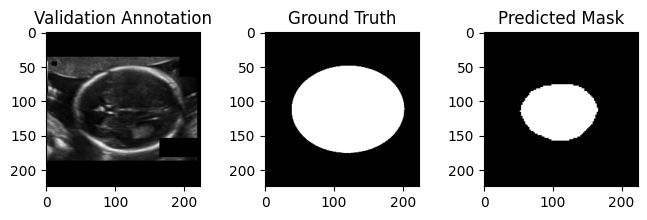

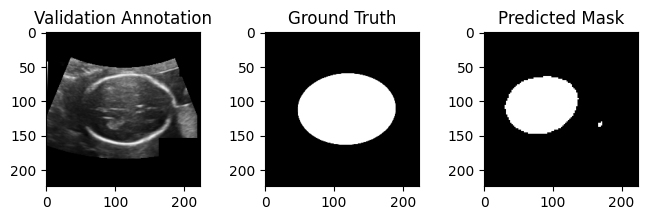

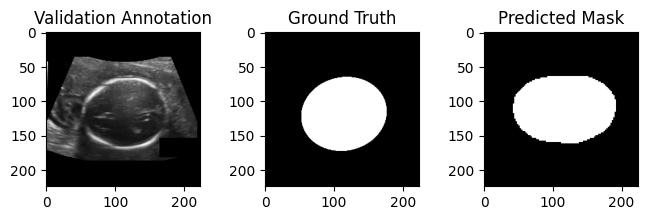

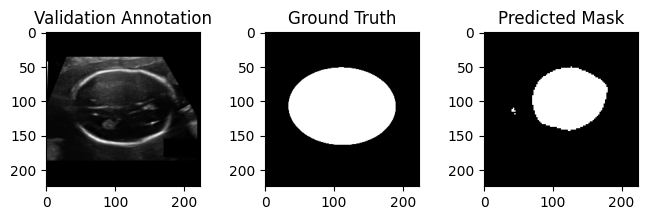

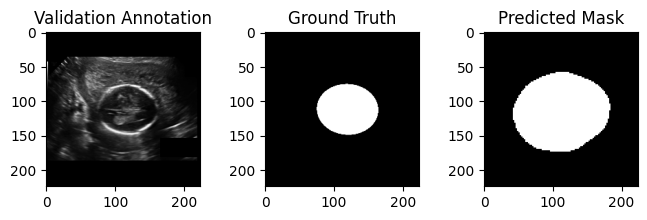

In [ ]:
predicted_images_validation, dice = trainer.predict_mask(validation_loader)
for i in range (0, 5):

  fig, axis = plt.subplots(1, 3, figsize=(8,2))
  axis[0].imshow(X_validation[i].permute(1, 2, 0))
  axis[0].set_title('Validation Annotation')
  axis[1].imshow(Y_validation[i].permute(1, 2, 0), cmap='gray')
  axis[1].set_title('Ground Truth')
  axis[2].imshow(predicted_images_validation[i], cmap='gray')
  axis[2].set_title('Predicted Mask')

  plt.show()

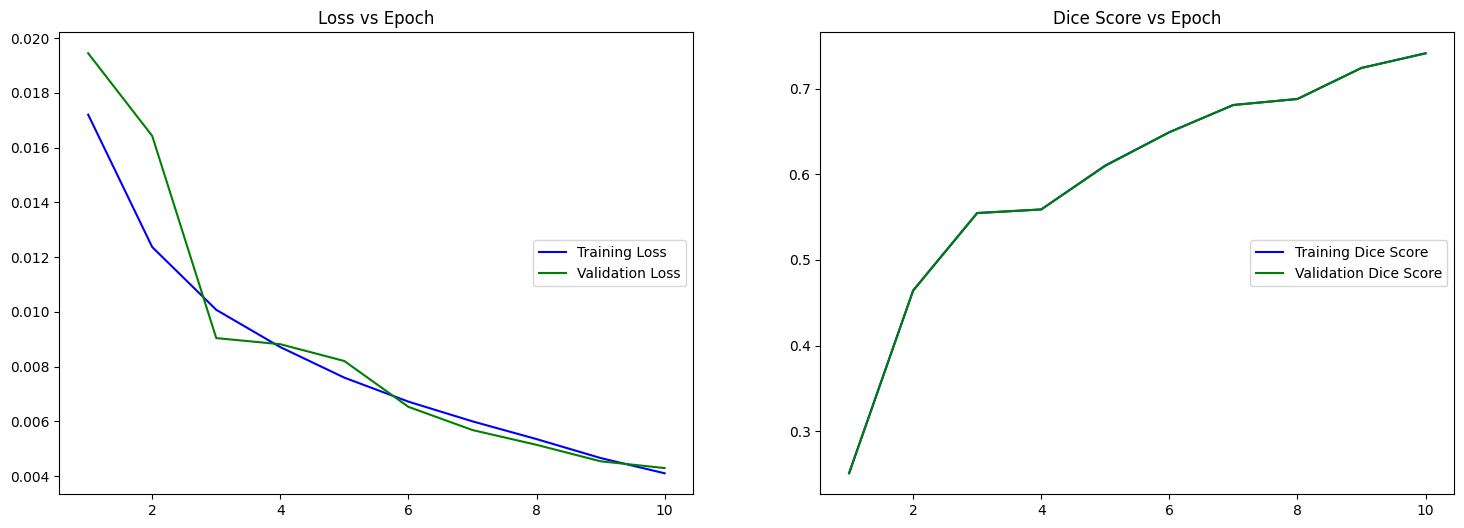

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(18, 6))

#ax2 = axis[0].twinx()
x_len = len(trainer.training_loss)
plt1 = axis[0].plot(range(1, x_len + 1), trainer.training_loss, label = 'Training Loss', c='blue')
plt2 = axis[0].plot(range(1, x_len + 1), trainer.test_loss, label = 'Validation Loss', c = 'green')
axis[0].set_title('Loss vs Epoch')
lns = plt1 + plt2
labs = [l.get_label() for l in lns]
axis[0].legend(lns, labs, loc='center right')

#ax2 = axis[1].twinx()
plt1 = axis[1].plot(range(1, x_len + 1), trainer.training_dice , label = 'Training Dice Score', c='blue')
plt2 = axis[1].plot(range(1, x_len + 1), trainer.test_dice, label = 'Validation Dice Score', c = 'green')
axis[1].set_title('Dice Score vs Epoch')
lns = plt1 + plt2
labs = [l.get_label() for l in lns]
axis[1].legend(lns, labs, loc='center right')
plt.show()


# UNet

Let us define our building blocks for the UNet - Block, Encoder, Decoder and the Model.

Again, we go only upto 512 channels due to GPU limit:

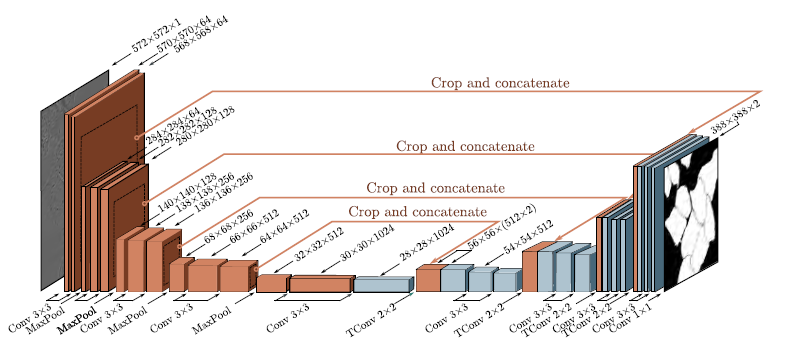

In [ ]:
class UNetBlock(nn.Module):
  def __init__(self, inChannels, outChannels):
    super().__init__()
    self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(outChannels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(outChannels)

  def forward(self, x):
    # CONV -> Batch Norm -> RELU -> CONV -> Batch Norm -> RELU
    return self.relu(self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x))))))

In [ ]:
class UNetEncoder(nn.Module):
	def __init__(self, channels=(3, 64, 128, 256, 512, 1024)):
		super().__init__()
		self.encoderBlocks = nn.ModuleList([UNetBlock(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
		self.max_pool = nn.MaxPool2d(2)
	def forward(self, x):
		resBlockOut = []
		for block in self.encoderBlocks:
			x = block(x)
			resBlockOut.append(x)
			x = self.max_pool(x)
		return resBlockOut



In [ ]:
class UNetDecoder(nn.Module):
	def __init__(self, channels=(1024, 512, 256, 128, 64)):
		super().__init__()
		self.channels = channels
		self.transposeConv = nn.ModuleList([nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2) for i in range(len(channels) - 1)])
		self.decoderBlocks = nn.ModuleList([UNetBlock(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])

	def forward(self, x, encoderOutputs):
		for i in range(len(self.channels) - 1):
			x = self.transposeConv[i](x)
			encFeat = self.crop(encoderOutputs[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.decoderBlocks[i](x)
		return x

	def crop(self, encFeatures, x):
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		return encFeatures

In [ ]:
class UNet(nn.Module):
  def __init__(self, encoderChannels=(3, 64, 128, 256, 512), decoderChannels=(512, 256, 128, 64), outClassCount=1):
    super().__init__()
    self.encoder = UNetEncoder(encoderChannels)
    self.decoder = UNetDecoder(decoderChannels)
    self.head = nn.Conv2d(decoderChannels[-1], outClassCount, 1)
    self.outputSize = (img_width,  img_height)

  def forward(self, x):
    encoderOutput = self.encoder(x)
    decoderOutput = self.decoder(encoderOutput[::-1][0], encoderOutput[::-1][1:])
    map = self.head(decoderOutput)
    map = F.interpolate(map, self.outputSize)
    return map

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate= 1e-3
max_epoch = 10
seed_everything()
model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_len = len(train_dataset)
test_len = len(validation_dataset)
train_loss = []
validation_loss = []

trainer = Trainer(model, criterion, optimizer,
                              max_epoch, train_loader,
                              validation_loader, train_len, test_len)
trainer.train_batch()


Running 22 Batches of Size 32 - Over 10 Epochs
Epoch: 1/10 | Training Loss: 0.011949182386909212 | Test Loss: 0.01582240641117096
Epoch: 2/10 | Training Loss: 0.006590205771582467 | Test Loss: 0.014014536241690318
Epoch: 3/10 | Training Loss: 0.005029160103627614 | Test Loss: 0.007278158267339071
Epoch: 4/10 | Training Loss: 0.003882921731897763 | Test Loss: 0.0035927393287420273
Epoch: 5/10 | Training Loss: 0.0031953676044940947 | Test Loss: 0.002997187872727712
Epoch: 6/10 | Training Loss: 0.002651521222931998 | Test Loss: 0.0029383693635463715
Epoch: 7/10 | Training Loss: 0.002125658414193562 | Test Loss: 0.0019197890907526017
Epoch: 8/10 | Training Loss: 0.0018711936101317406 | Test Loss: 0.001890107753376166
Epoch: 9/10 | Training Loss: 0.0017665678156273705 | Test Loss: 0.0020040059089660644
Epoch: 10/10 | Training Loss: 0.0015862305196268217 | Test Loss: 0.0014561442658305168
Training Dice Score: 0.9082088470458984
Validation Dice Score: 0.9083600640296936


## Observation:

We see huge increase in Dice Score for Train and Validation Dataset for UNet.

Reason being, in UNet, we are using Residual Network Architecture as against simple Encoder-Decoder

Let us see the Validation Data set First 5 Images - Image, Ground Truth and Predicted Mask:

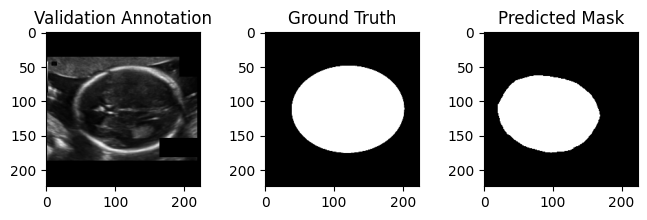

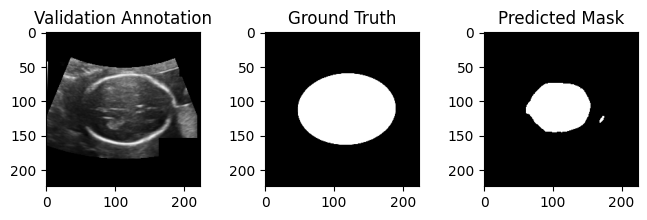

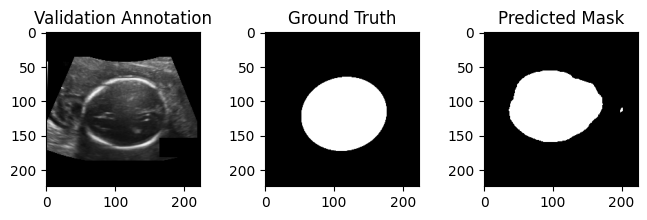

In [ ]:
predicted_images_validation, dice = trainer.predict_mask(validation_loader)
for i in range (0, 3):

  fig, axis = plt.subplots(1, 3, figsize=(8,2))
  axis[0].imshow(X_validation[i].permute(1, 2, 0))
  axis[0].set_title('Validation Annotation')
  axis[1].imshow(Y_validation[i].permute(1, 2, 0), cmap='gray')
  axis[1].set_title('Ground Truth')
  axis[2].imshow(predicted_images_validation[i], cmap='gray')
  axis[2].set_title('Predicted Mask')

  plt.show()

# Plotting the Losses and Dice Score vs Epoch:

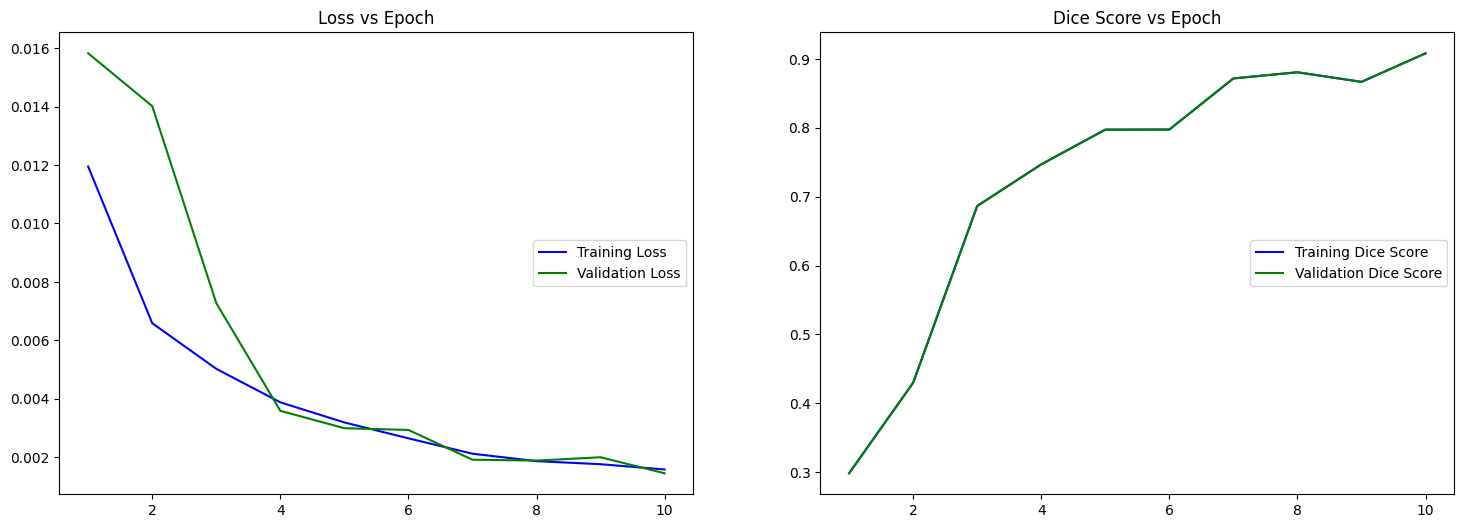

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(18, 6))

#ax2 = axis[0].twinx()
x_len = len(trainer.training_loss)
plt1 = axis[0].plot(range(1, x_len + 1), trainer.training_loss, label = 'Training Loss', c='blue')
plt2 = axis[0].plot(range(1, x_len + 1), trainer.test_loss, label = 'Validation Loss', c = 'green')
axis[0].set_title('Loss vs Epoch')
lns = plt1 + plt2
labs = [l.get_label() for l in lns]
axis[0].legend(lns, labs, loc='center right')

#ax2 = axis[1].twinx()
plt1 = axis[1].plot(range(1, x_len + 1), trainer.training_dice , label = 'Training Dice Score', c='blue')
plt2 = axis[1].plot(range(1, x_len + 1), trainer.test_dice, label = 'Validation Dice Score', c = 'green')
axis[1].set_title('Dice Score vs Epoch')
lns = plt1 + plt2
labs = [l.get_label() for l in lns]
axis[1].legend(lns, labs, loc='center right')
plt.show()

In [ ]:
predicted_images_test, dice = trainer.predict_mask_test_data(test_loader)


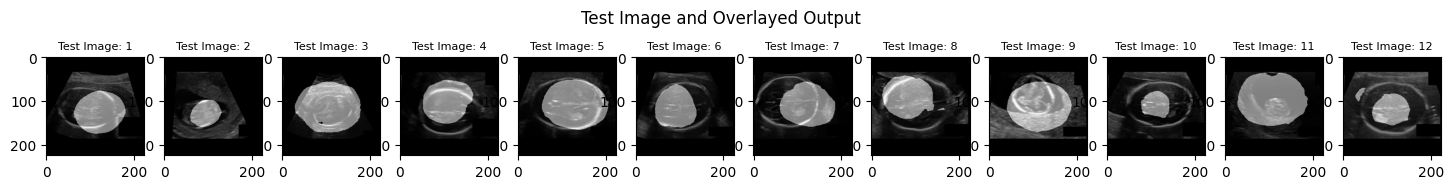

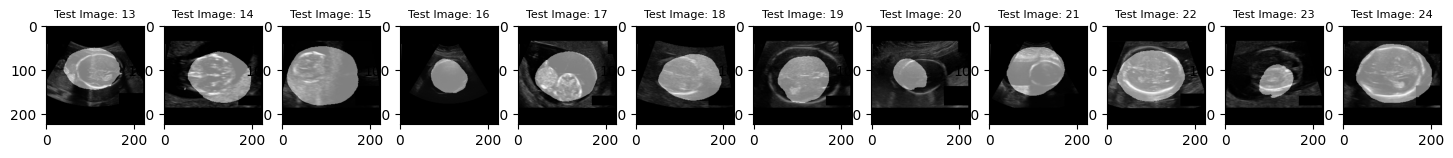

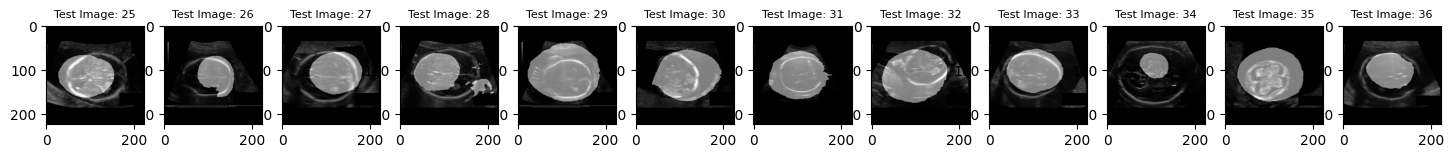

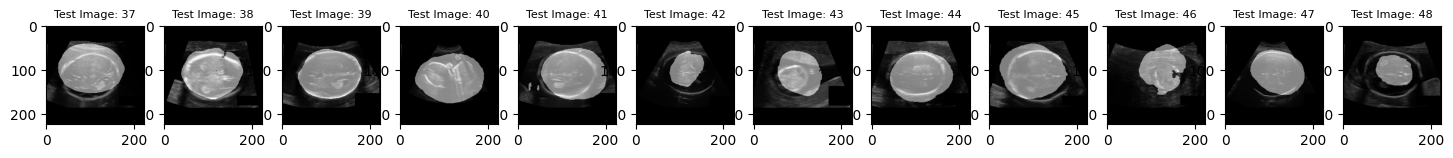

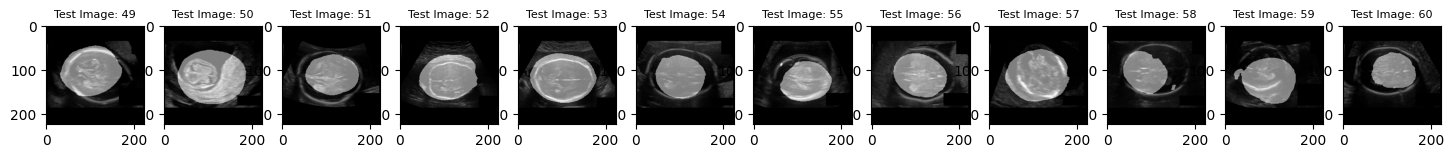

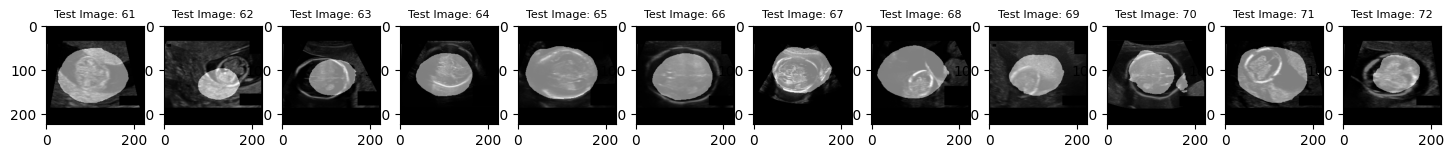

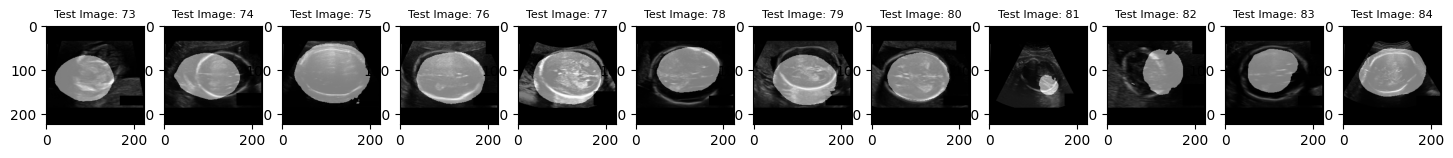

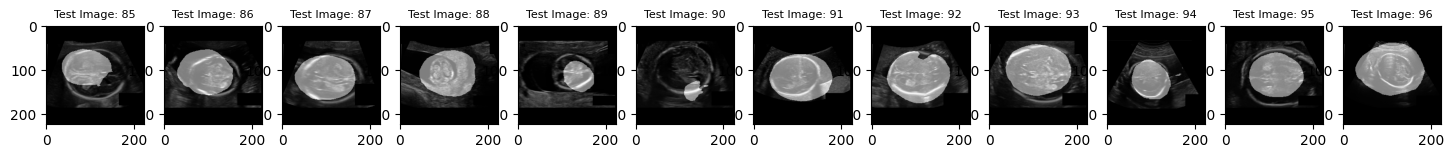

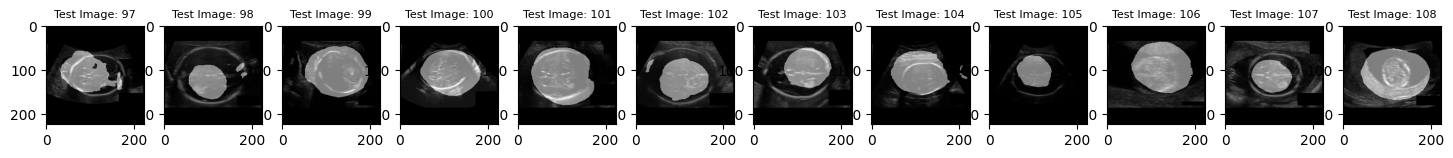

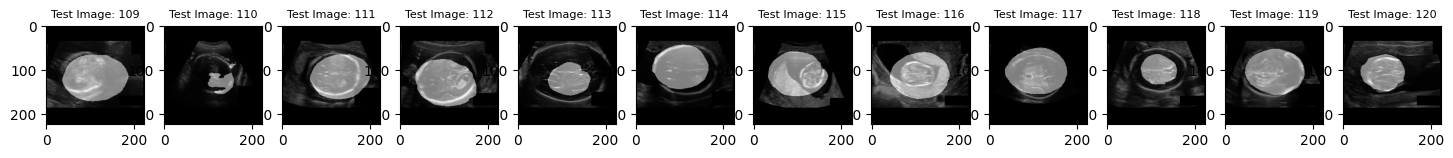

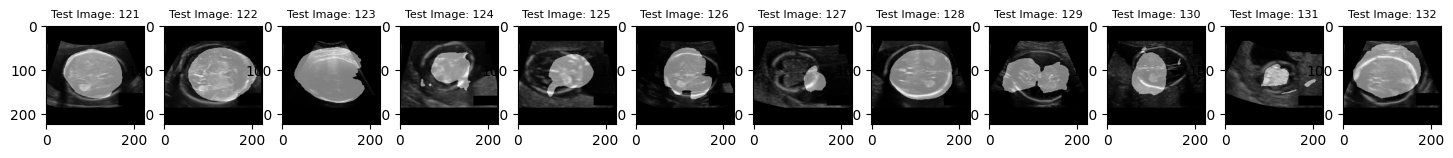

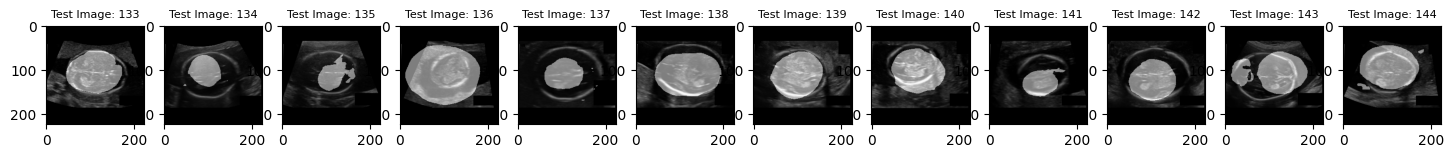

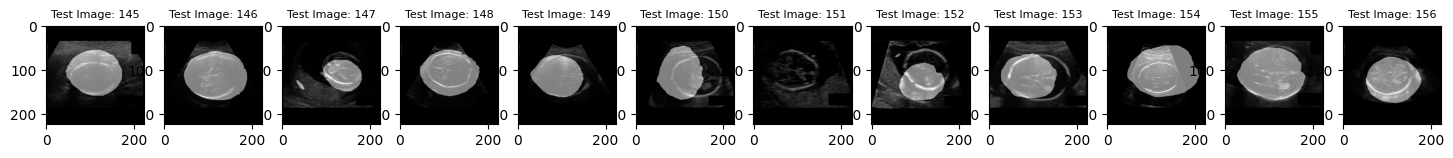

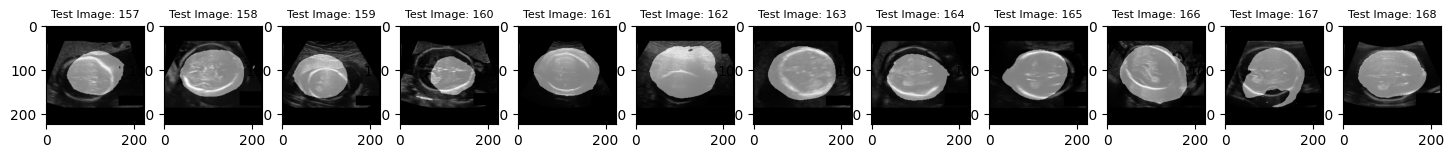

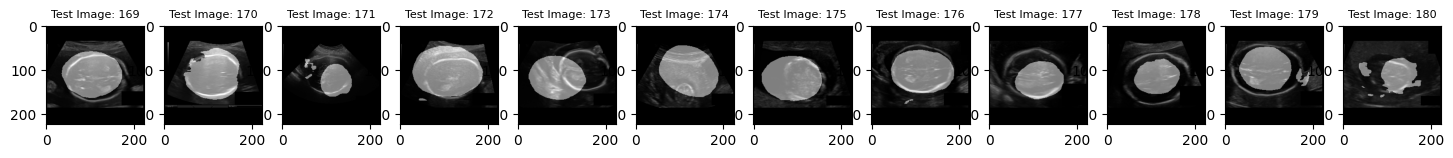

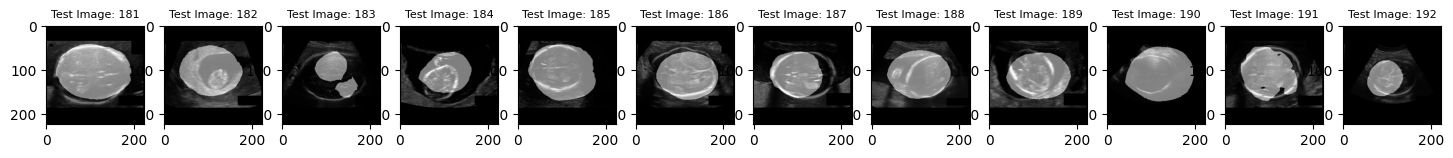

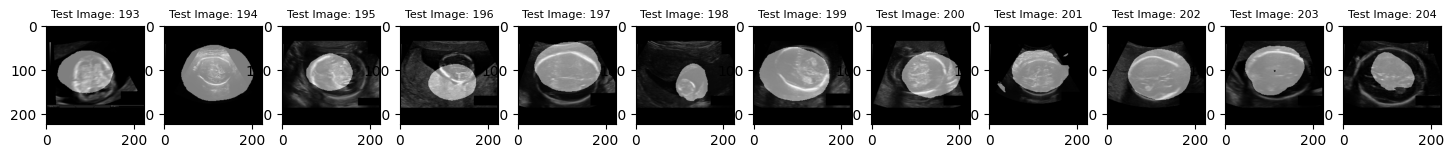

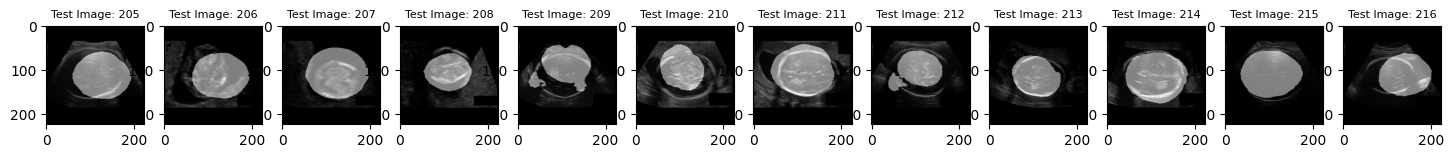

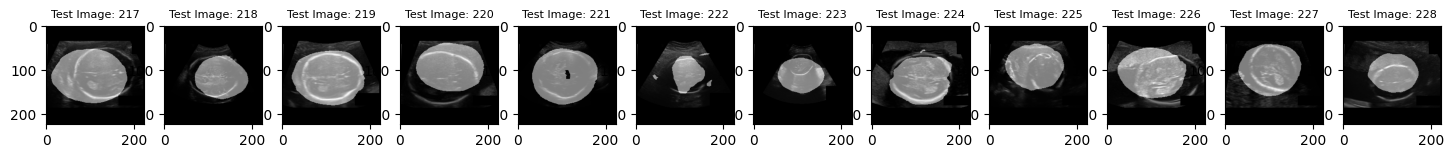

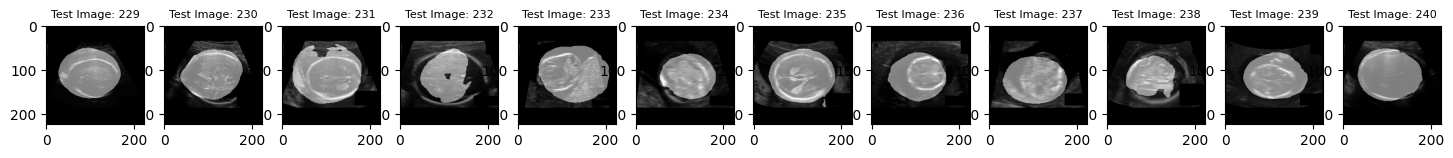

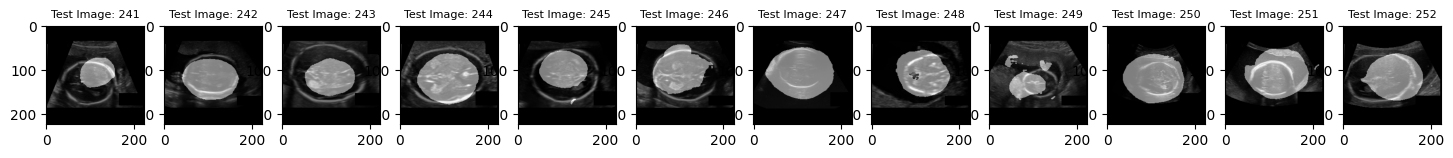

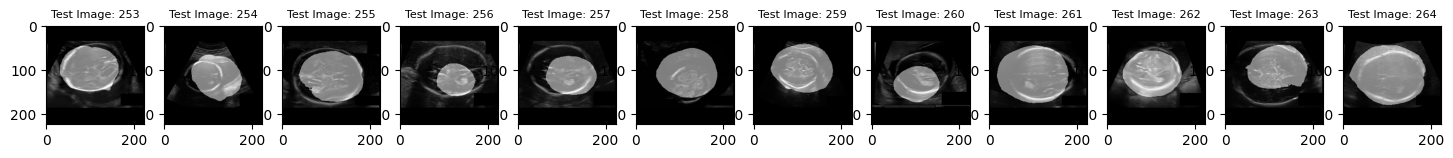

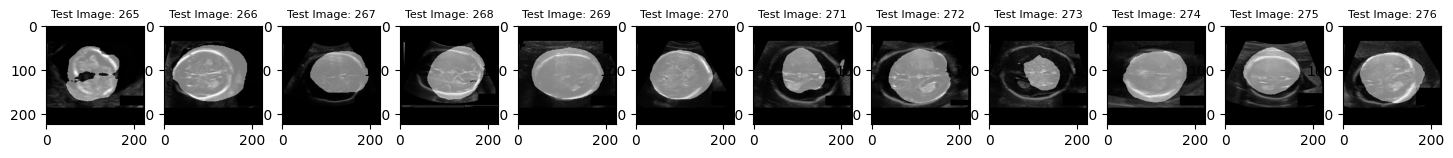

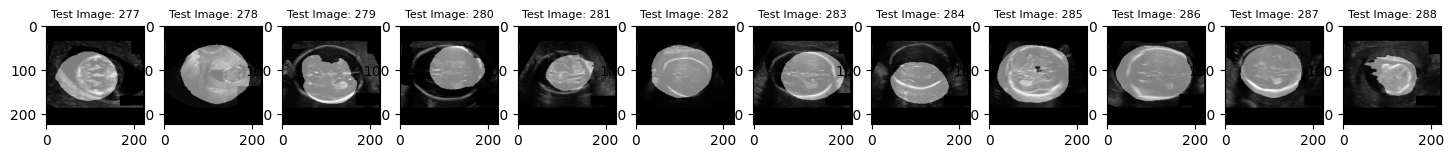

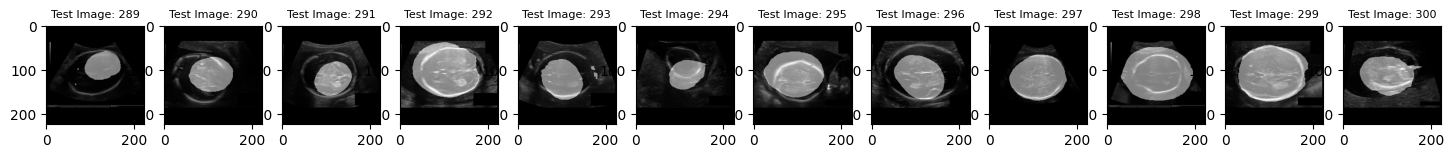

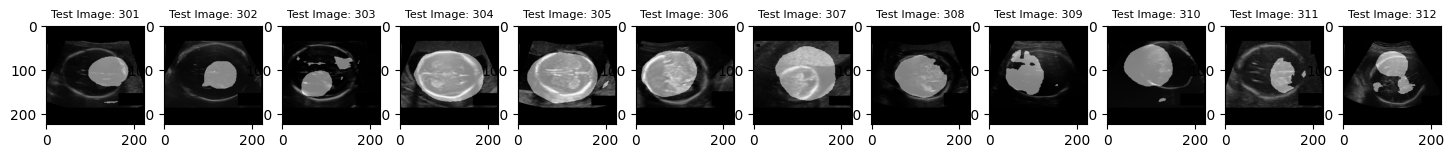

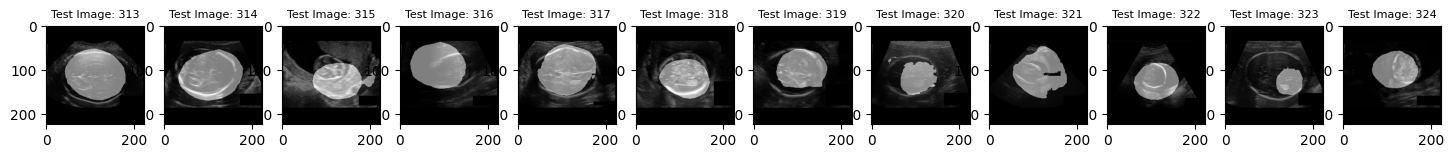

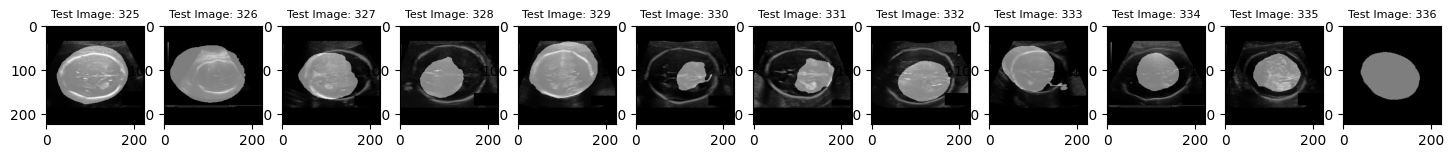

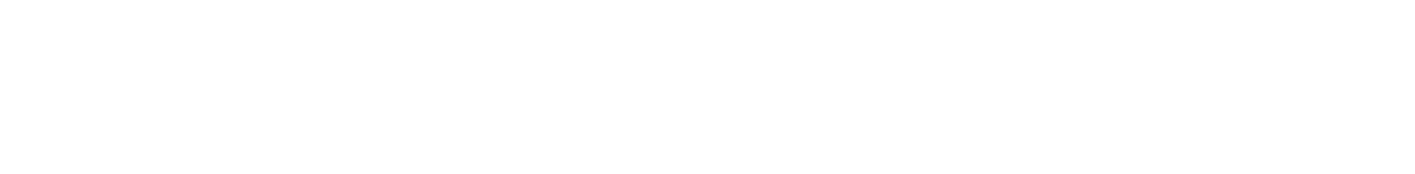

In [ ]:
imagePerRow = 12
rows = int(len(X_test) / imagePerRow) + 1
for i in range (0, rows):
  fig, axis = plt.subplots(1, imagePerRow, figsize=(18,2))
  if i ==0:
    fig.suptitle('Test Image and Overlayed Output')
  m = 0
  for j in range(i * imagePerRow, (i + 1) * imagePerRow ):
    if j < len(X_test):
      axis[m].imshow(X_test[j].permute(1, 2, 0))
      axis[m].imshow(predicted_images_test[j], cmap='gray', alpha = 0.5)
      axis[m].set_title(f"Test Image: {j + 1}", fontsize=8)
    else:
      axis[m].axis('off')
    m += 1
  plt.show()